In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import keras
import pickle
import os

Using TensorFlow backend.


In [4]:
from LSTM import *
from gen_train_test_data import *
from simtools import *
%load_ext autoreload
%autoreload 2

with open("model/LSTMv2_{}_{}.p".format(train_date_list[0],train_date_list[-1]),"rb") as f:
        l=pickle.load(f)
        
with open("model/LSTMv2_scaler_{}_{}.p".format(train_date_list[0],train_date_list[-1]),"rb") as f:
        scaler=pickle.load(f)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
for date in test_date_list:
    if not os.path.exists("test_result/x_test_{}.p".format(date)):
        x,idx=create_test_dataset(ticker=ticker,time_steps = time_steps, input_scaler=scaler, date=date)
        print(x.shape,idx.shape)
        
        with open("test_result/x_test_{}.p".format(date),"wb") as f:
                pickle.dump(x,f)
        signal=l.predict(x)
        with open("test_result/signal_test_{}.p".format(date),"wb") as f:
                pickle.dump(signal,f)
    
    log_message( "{} finished".format(date) )

2020-04-04 20:21:25:061022: 20190117 finished
2020-04-04 20:21:25:067013: 20190118 finished
128539
(128490, 50, 4) (128490,)
2020-04-04 20:22:31:959795: 20190122 finished
147241
(147192, 50, 4) (147192,)
2020-04-04 20:23:43:539844: 20190123 finished
87977
(87928, 50, 4) (87928,)
2020-04-04 20:24:27:460928: 20190124 finished
80529
(80480, 50, 4) (80480,)
2020-04-04 20:25:04:956324: 20190125 finished
71426
(71377, 50, 4) (71377,)
2020-04-04 20:25:41:046654: 20190128 finished
51737
(51688, 50, 4) (51688,)
2020-04-04 20:26:07:128329: 20190129 finished
108229
(108180, 50, 4) (108180,)
2020-04-04 20:26:59:775910: 20190130 finished
133965
(133916, 50, 4) (133916,)
2020-04-04 20:28:04:790972: 20190131 finished


In [87]:
test_taq=dict()

for date in test_date_list:
    if os.path.exists("test_result/x_test_{}.p".format(date)) and os.path.exists(data_dir+"quotes_{}_TSLA.csv".format(date)):

        with open("test_result/signal_test_{}.p".format(date),"rb") as f:
            signal=pickle.load(f)
        print(signal.shape)
        
        # generate signal and attach it to original df
        signal_discrete=signal.argmax(axis=1)-1
        signal_continuous=np.dot(signal,np.array([[-1],[0],[1]])).ravel()
        
        trades = pd.read_csv(data_dir+'trades_{}_{}.csv'.format(date, ticker),index_col=[0],parse_dates=[0])
        N=len(trades)

        signal_discrete=np.concatenate((np.zeros(N-len(signal_discrete))+np.nan,signal_discrete), axis=0)
        signal_continuous=np.concatenate((np.zeros(N-len(signal_continuous))+np.nan,signal_continuous), axis=0)

        trades[["signal_discrete","signal_continuous"]]=pd.DataFrame({"signal_discrete":signal_discrete, "signal_continuous":signal_continuous},index=trades.index)
        # print(trades.shape)
        
        # merge TAQ
        quotes=pd.read_csv(data_dir+"quotes_{}_TSLA.csv".format(date),index_col=[0],parse_dates=[0])
        taq=makeTAQfile(trades, quotes)
        print(taq.shape)
        test_taq[date]=taq
        
        log_message( "{} finished".format(date) )

(40365, 3)
2020-04-04 23:22:03:195350: start merge
2020-04-04 23:22:03:223275: end merge
(50301, 11)
2020-04-04 23:22:03:229259: 20190117 finished
(267068, 3)
2020-04-04 23:22:03:705024: start merge
2020-04-04 23:22:03:853615: end merge
(428445, 11)
2020-04-04 23:22:03:857610: 20190118 finished
(87928, 3)
2020-04-04 23:22:04:047073: start merge
2020-04-04 23:22:04:104920: end merge
(113260, 11)
2020-04-04 23:22:04:113928: 20190124 finished
(80480, 3)
2020-04-04 23:22:04:308378: start merge
2020-04-04 23:22:04:354252: end merge
(99211, 11)
2020-04-04 23:22:04:358242: 20190125 finished
(71377, 3)
2020-04-04 23:22:04:487893: start merge
2020-04-04 23:22:04:538760: end merge
(89710, 11)
2020-04-04 23:22:04:542749: 20190128 finished
(51688, 3)
2020-04-04 23:22:04:646470: start merge
2020-04-04 23:22:04:675392: end merge
(66041, 11)
2020-04-04 23:22:04:678384: 20190129 finished
(108180, 3)
2020-04-04 23:22:04:908771: start merge
2020-04-04 23:22:04:979604: end merge
(202140, 11)
2020-04-04 2

# Test vwap

In [70]:
import vwap2 as vw
matplotlib.rcParams[ 'figure.figsize' ] = ( 16, 9 )
vwap_coefs = [ 9.95503275e-03, -1.01533564e-04,  5.73879785e-07, -1.47027197e-09, 1.38993793e-12]
test_date_list_new=list(test_taq.keys())
day = test_taq[test_date_list_new[0]]
day[~day.bid_px.isna()]

,bid_px,bid_size,ask_px,ask_size,natbbo_ind,qu_source,symbol,trade_size,trade_px,signal_discrete,signal_continuous
2019-01-17 09:30:00.645,346.05,3.0,346.70,8.0,4.0,N,TSLA,5.0,346.25,NaN,NaN
2019-01-17 09:30:00.645,346.05,3.0,346.70,8.0,4.0,N,TSLA,80.0,346.53,NaN,NaN
2019-01-17 09:30:00.645,346.05,3.0,346.70,8.0,4.0,N,TSLA,80.0,346.53,NaN,NaN
2019-01-17 09:30:00.909,346.05,3.0,346.25,1.0,4.0,N,TSLA,50.0,346.25,NaN,NaN
2019-01-17 09:30:00.909,346.05,3.0,346.25,1.0,4.0,N,TSLA,3.0,346.09,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2019-01-17 15:59:59.629,347.31,26.0,347.49,5.0,4.0,N,TSLA,NaN,NaN,NaN,NaN
2019-01-17 15:59:59.779,347.31,27.0,347.49,5.0,4.0,N,TSLA,NaN,NaN,NaN,NaN
2019-01-17 15:59:59.779,347.31,28.0,347.49,5.0,4.0,N,TSLA,NaN,NaN,NaN,NaN
2019-01-17 15:59:59.780,347.31,29.0,347.49,5.0,4.0,N,TSLA,NaN,NaN,NaN,NaN


In [110]:
from color_txj.color_tao import color_tao as taolaoshi

def test_vwap(day, order_quantity, order_side, schedule_coef = -1.0, tick_coef = 0., LSTM_coef = 1.,LSTM=True):
    results = vw.algo_loop(day, order_side, order_quantity, vwap_coefs, schedule_coef = schedule_coef,\
                           tick_coef = tick_coef, LSTM_coef = LSTM_coef, LSTM=LSTM)
    display_result(results,False)
    return results

def display_result(results,plot=True):
    data = results['trades']
    if plot:
        print("FV and midpoints:")
        plt.plot(results['fair_values'].index,results['fair_values'].values,color=taolaoshi[2])
        plt.plot(results['midpoints'].index,results['midpoints'].values,color=taolaoshi[1])
        plt.legend(["fair_values","midpoints"])
        plt.show()
        print("Trade prices:")
        plt.plot(data.price.index,data.price.values,color=taolaoshi[0])
        plt.show()
    print("percentage of aggressive order:",np.mean(data['trade_type']=="a"))
    print("last_min_order:",results['last_min_order'])
    print("avg price:",results['avg_price'])
    print("day_vwap price:",results['day_vwap'])
    print("avg - day_vwap:",results['avg_price'] - results['day_vwap'])
    
i=0

vwap_list=[]
# avg_list_tick=[]
avg_list_LSTM=[]
avg_spread=[]

LSTM_coef=0.1
print(LSTM_coef)

for date in test_taq.keys():
    print("-------------------------------------------------------------------------------------------------")
    day=test_taq[date]
    # r_tick=test_vwap(day, order_quantity=300000, order_side="s", schedule_coef = -1.0, tick_coef = 1., LSTM_coef = 0.,LSTM=False)
    r_LSTM=test_vwap(day, order_quantity=300000, order_side="s", schedule_coef = -1.0, tick_coef = 0., LSTM_coef = LSTM_coef,LSTM=LSTM_coef)
    
    vwap_list.append(r_LSTM['day_vwap'])
    # avg_list_tick.append(r_tick['avg_price'])
    avg_list_LSTM.append(r_LSTM['avg_price'])
    avg_spread.append(r_LSTM["avg_spread"])
    
    log_message( "{} finished".format(date) )

0.5
-------------------------------------------------------------------------------------------------
2020-04-05 00:33:07:145596: Beginning VWAP run: s 300000 shares
Average stock spread for sample: 0.1776
2020-04-05 00:33:07:156565: starting main loop
2020-04-05 00:33:31:621186: end simulation loop
2020-04-05 00:33:31:625183: order analytics
2020-04-05 00:33:31:629135: VWAP run complete.
percentage of aggressive order: 0.0470668485675307
last_min_order: 81834.0
avg price: 347.2941579
day_vwap price: 347.7609699903627
avg - day_vwap: -0.46681209036268
2020-04-05 00:33:31:649080: 20190117 finished
-------------------------------------------------------------------------------------------------
2020-04-05 00:33:31:652111: Beginning VWAP run: s 300000 shares
Average stock spread for sample: 0.0542
2020-04-05 00:33:31:670025: starting main loop
2020-04-05 00:36:07:286961: end simulation loop
2020-04-05 00:36:07:291948: order analytics
2020-04-05 00:36:07:294940: VWAP run complete.
percenta

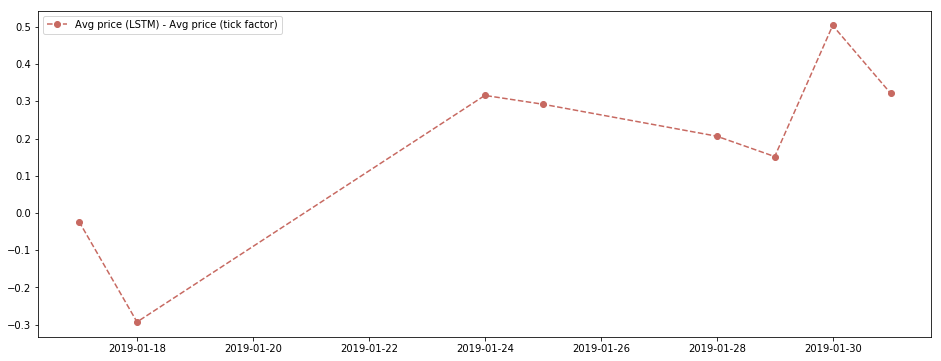

In [112]:
df_compare=pd.DataFrame({"Tick factor":avg_list_tick,"LSTM factor":avg_list_LSTM},index=pd.to_datetime(list(test_taq.keys())))
df_compare["Avg LSTM - Avg factor"]=df_compare["LSTM factor"]-df_compare["Tick factor"]
fig,ax=plt.subplots(figsize=(16,6))
ax.plot(df_compare.index,df_compare["Avg LSTM - Avg factor"].values,'o--',color=taolaoshi[1])
plt.legend(["Avg price (LSTM) - Avg price (tick factor)"])

In [97]:
avg_list_tick

[347.31697603333333,
 309.24935586666663,
 289.02730693333336,
 295.20656499999984,
 294.1796657333333,
 295.99002229999996,
 305.11141906666666,
 305.4490429333333]